Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# Lab 6: Attention Mechanisms - The Heart of Transformers

## Lab Overview

Welcome to a comprehensive exploration of attention mechanisms, the revolutionary innovation that transformed natural language processing and enabled the current era of large language models. This lab provides deep insights into the mathematical foundations and practical implementations of attention.

**Lab Goal**: Master the attention mechanism from theoretical foundations to practical implementation, including self-attention, multi-head attention, and causal masking.

## Learning Objectives

By the end of this lab, you will be able to:

1. **Understand Self-Attention**: Grasp the mathematical intuition behind attention mechanisms
2. **Implement Attention Components**: Build Query, Key, Value projections from scratch
3. **Master Multi-Head Attention**: Understand parallel attention heads and their benefits
4. **Apply Causal Masking**: Implement autoregressive attention for language modeling
5. **Connect to Transformers**: Understand how attention enables modern language models
---

## 1. Environment Setup

In [ ]:
# Core libraries for attention implementation
import math
from typing import Optional, tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda
PyTorch version: 2.9.1+rocm7.10.0
GPU: Radeon 8060S Graphics
GPU Memory: 103.1 GB


## 2. Self-Attention Fundamentals

Self-attention allows each position in a sequence to attend to all positions in the same sequence. This mechanism enables the model to capture complex relationships and dependencies within the input.

**Core Components:**

**Query (Q)**: Represents "what am I looking for?"
- Each position creates a query vector asking what information it needs
- Computed by: `Q = X * W_q`

**Key (K)**: Represents "what do I have to offer?"
- Each position creates a key vector describing what information it contains
- Computed by: `K = X * W_k`

**Value (V)**: Represents "what information do I actually contain?"
- Each position creates a value vector with the actual information to be shared
- Computed by: `V = X * W_v`

**Attention Mechanism Steps:**
1. **Compute Scores**: Calculate similarity between queries and keys: `QK^T`
2. **Scale**: Divide by `√d_k` for numerical stability
3. **Apply Softmax**: Convert scores to probabilities
4. **Weighted Sum**: Multiply probabilities with values: `softmax(QK^T/√d_k)V`

**Mathematical Intuition:**
The attention score between position i and j represents how much position i should focus on position j. Higher scores mean stronger relationships and more information flow.

In [2]:
# Initialize Attention Components and Test Data
print("Setting up attention mechanism components")

# Model parameters
batch_size = 2
seq_len = 3
hidden_dim = 4
head_dim = 2  # For multi-head attention later

# Create sample input embeddings
hidden_states = torch.randn(batch_size, seq_len, hidden_dim).to(device)
print(f"Input shape: {hidden_states.shape}")
print(f"Input tensor:\n{hidden_states}")

# Initialize projection layers for Q, K, V
q_proj = nn.Linear(hidden_dim, hidden_dim, bias=False).to(device)
k_proj = nn.Linear(hidden_dim, hidden_dim, bias=False).to(device)
v_proj = nn.Linear(hidden_dim, hidden_dim, bias=False).to(device)
o_proj = nn.Linear(hidden_dim, hidden_dim, bias=False).to(device)  # Output projection

print("\nProjection layers initialized:")
print(f"- Query projection: {hidden_dim} -> {hidden_dim}")
print(f"- Key projection: {hidden_dim} -> {hidden_dim}")
print(f"- Value projection: {hidden_dim} -> {hidden_dim}")
print(f"- Output projection: {hidden_dim} -> {hidden_dim}")

# Initialize weights with small values for stability
with torch.no_grad():
    for proj in [q_proj, k_proj, v_proj, o_proj]:
        nn.init.xavier_uniform_(proj.weight)

print("Projection weights initialized with Xavier uniform distribution")

Setting up attention mechanism components
Input shape: torch.Size([2, 3, 4])
Input tensor:
tensor([[[ 1.9269,  1.4873,  0.9007, -2.1055],
         [ 0.6784, -1.2345, -0.0431, -1.6047],
         [ 0.3559, -0.6866, -0.4934,  0.2415]],

        [[-1.1109,  0.0915, -2.3169, -0.2168],
         [-0.3097, -0.3957,  0.8034, -0.6216],
         [-0.5920, -0.0631, -0.8286,  0.3309]]], device='cuda:0')

Projection layers initialized:
- Query projection: 4 -> 4
- Key projection: 4 -> 4
- Value projection: 4 -> 4
- Output projection: 4 -> 4
Projection weights initialized with Xavier uniform distribution


In [3]:
# Compute Query, Key, and Value Projections
print("Computing Q, K, V projections from input embeddings")

# Apply linear transformations to create Q, K, V
q = q_proj(hidden_states)  # Query: "what am I looking for?"
k = k_proj(hidden_states)  # Key: "what do I have to offer?"
v = v_proj(hidden_states)  # Value: "what information do I contain?"

print("\nProjection results:")
print(f"Query (Q) shape: {q.shape}")
print(f"Key (K) shape: {k.shape}")
print(f"Value (V) shape: {v.shape}")

# Analyze the projections
print("\nQuery statistics:")
print(f"- Mean: {q.mean().item():.4f}")
print(f"- Std: {q.std().item():.4f}")
print(f"- Range: [{q.min().item():.4f}, {q.max().item():.4f}]")

print("\nFirst query vector (batch 0, position 0):")
print(f"Q[0,0,:] = {q[0, 0, :]}")

print("\nFirst key vector (batch 0, position 0):")
print(f"K[0,0,:] = {k[0, 0, :]}")

print("\nFirst value vector (batch 0, position 0):")
print(f"V[0,0,:] = {v[0, 0, :]}")

# Demonstrate that each position has its own Q, K, V vectors
print("\nPosition-specific vectors for batch 0:")
for pos in range(seq_len):
    q_norm = q[0, pos, :].norm().item()
    k_norm = k[0, pos, :].norm().item()
    v_norm = v[0, pos, :].norm().item()
    print(f"Position {pos}: Q_norm={q_norm:.3f}, K_norm={k_norm:.3f}, V_norm={v_norm:.3f}")

Computing Q, K, V projections from input embeddings

Projection results:
Query (Q) shape: torch.Size([2, 3, 4])
Key (K) shape: torch.Size([2, 3, 4])
Value (V) shape: torch.Size([2, 3, 4])

Query statistics:
- Mean: 0.2677
- Std: 1.0137
- Range: [-2.4316, 2.5528]

First query vector (batch 0, position 0):
Q[0,0,:] = tensor([ 0.6328, -0.4809, -2.4316,  1.2492], device='cuda:0',
       grad_fn=<SelectBackward0>)

First key vector (batch 0, position 0):
K[0,0,:] = tensor([0.6881, 0.3357, 1.3903, 1.4260], device='cuda:0',
       grad_fn=<SelectBackward0>)

First value vector (batch 0, position 0):
V[0,0,:] = tensor([1.3583, 2.0770, 1.7692, 1.3241], device='cuda:0',
       grad_fn=<SelectBackward0>)

Position-specific vectors for batch 0:
Position 0: Q_norm=2.847, K_norm=2.134, V_norm=3.323
Position 1: Q_norm=3.615, K_norm=2.229, V_norm=2.604
Position 2: Q_norm=1.177, K_norm=0.738, V_norm=0.912


## 3. Attention Score Computation and Masking

Now we'll compute attention scores and explore masking techniques for different types of attention patterns.

**Attention Score Computation:**
1. **Dot Product**: Compute similarity between queries and keys: `QK^T`
2. **Scaling**: Divide by `√d_k` to prevent extremely large values
3. **Masking**: Apply masks to control which positions can attend to others
4. **Softmax**: Convert scores to probability distribution

**Types of Attention Masks:**
- **Causal Mask**: For autoregressive models (GPT-style), prevents looking at future tokens
- **Padding Mask**: Ignores padded positions in variable-length sequences
- **Custom Masks**: Application-specific attention patterns

**Mathematical Details:**
- **Scaling Factor**: `√d_k` prevents softmax from saturating for large dimensions
- **Causal Pattern**: Lower triangular matrix ensures position i only sees positions ≤ i
- **Mask Values**: Set to -∞ before softmax to get 0 probability after softmax

In [4]:
# Compute Attention Scores with Detailed Analysis
print("Computing attention scores: QK^T / sqrt(d_k)")

# Step 1: Compute raw attention scores
scale_factor = math.sqrt(hidden_dim)
attention_scores = torch.matmul(q, k.transpose(-2, -1)) / scale_factor

print(f"Attention scores shape: {attention_scores.shape}")
print(f"Scale factor (sqrt(d_k)): {scale_factor}")
print("Raw attention scores (batch 0):")
print(attention_scores[0])

# Analyze attention patterns
print("\nAttention score statistics:")
print(f"- Mean: {attention_scores.mean().item():.4f}")
print(f"- Std: {attention_scores.std().item():.4f}")
print(f"- Range: [{attention_scores.min().item():.4f}, {attention_scores.max().item():.4f}]")

# Step 2: Create and apply causal mask
print("\nCreating causal mask for autoregressive attention:")
causal_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
causal_mask = causal_mask.to(attention_scores.device)
print(f"Causal mask shape: {causal_mask.shape}")
print("Causal mask pattern:")
print(causal_mask.int())

# Apply mask by setting masked positions to very negative values
masked_scores = attention_scores.clone()
masked_scores = masked_scores.masked_fill(causal_mask, float("-inf"))

print("\nMasked attention scores (batch 0):")
print(masked_scores[0])

# Step 3: Demonstrate different masking strategies
print("\nDemonstrating padding mask:")
# Simulate padding mask (position 2 is padded)
padding_mask = torch.zeros(batch_size, seq_len).bool()
padding_mask[1, 2] = True  # Mark position 2 in batch 1 as padded

print("Padding mask:")
print(padding_mask)

# Apply padding mask
padding_masked_scores = attention_scores.clone()
padding_masked_scores[padding_mask.unsqueeze(1).expand(-1, seq_len, -1)] = float("-inf")

print("Scores with padding mask (batch 1):")
print(padding_masked_scores[1])

Computing attention scores: QK^T / sqrt(d_k)
Attention scores shape: torch.Size([2, 3, 3])
Scale factor (sqrt(d_k)): 2.0
Raw attention scores (batch 0):
tensor([[-0.6626,  1.6580,  0.2725],
        [ 2.1767,  3.5629,  0.7366],
        [ 1.0602,  1.0616,  0.1678]], device='cuda:0',
       grad_fn=<SelectBackward0>)

Attention score statistics:
- Mean: 0.4682
- Std: 1.1305
- Range: [-1.3013, 3.5629]

Creating causal mask for autoregressive attention:
Causal mask shape: torch.Size([3, 3])
Causal mask pattern:
tensor([[0, 1, 1],
        [0, 0, 1],
        [0, 0, 0]], device='cuda:0', dtype=torch.int32)

Masked attention scores (batch 0):
tensor([[-0.6626,    -inf,    -inf],
        [ 2.1767,  3.5629,    -inf],
        [ 1.0602,  1.0616,  0.1678]], device='cuda:0',
       grad_fn=<SelectBackward0>)

Demonstrating padding mask:
Padding mask:
tensor([[False, False, False],
        [False, False,  True]])
Scores with padding mask (batch 1):
tensor([[-0.0569, -0.1291,    -inf],
        [-1.3013

In [5]:
# Apply Softmax and Compute Attention Output
print("Applying softmax to convert scores to attention weights")

# Step 1: Apply softmax to get attention probabilities
attention_weights = F.softmax(masked_scores, dim=-1)
print(f"Attention weights shape: {attention_weights.shape}")
print("Attention weights (batch 0):")
print(attention_weights[0])

# Verify softmax properties
print("\nSoftmax verification:")
for batch in range(batch_size):
    row_sums = attention_weights[batch].sum(dim=-1)
    print(f"Batch {batch} row sums: {row_sums} (should sum to 1.0)")

# Step 2: Apply attention weights to values
attention_output = torch.matmul(attention_weights, v)
print(f"\nAttention output shape: {attention_output.shape}")
print("Attention output (batch 0):")
print(attention_output[0])

# Step 3: Analyze what attention is doing
print("\nAttention interpretation:")
print("Position 0 attention weights:", attention_weights[0, 0, :])
print("Position 0 can only attend to itself (causal mask)")
print()
print("Position 1 attention weights:", attention_weights[0, 1, :])
print("Position 1 can attend to positions 0 and 1")
print()
print("Position 2 attention weights:", attention_weights[0, 2, :])
print("Position 2 can attend to all positions 0, 1, and 2")

# Step 4: Compare input vs output
print("\nInput vs Output comparison (batch 0, position 0):")
print(f"Original hidden state: {hidden_states[0, 0, :]}")
print(f"Attention output:     {attention_output[0, 0, :]}")
print(f"Change magnitude: {(attention_output[0, 0, :] - hidden_states[0, 0, :]).norm().item():.4f}")

# Step 5: Demonstrate attention focusing
print("\nAttention focusing analysis:")
max_attention = attention_weights.max(dim=-1)[0]
print("Maximum attention weights per position:")
print(f"Batch 0: {max_attention[0]}")
print(f"Batch 1: {max_attention[1]}")
print("Higher values indicate more focused attention")

Applying softmax to convert scores to attention weights
Attention weights shape: torch.Size([2, 3, 3])
Attention weights (batch 0):
tensor([[1.0000, 0.0000, 0.0000],
        [0.2000, 0.8000, 0.0000],
        [0.4147, 0.4153, 0.1699]], device='cuda:0', grad_fn=<SelectBackward0>)

Softmax verification:
Batch 0 row sums: tensor([1., 1., 1.], device='cuda:0', grad_fn=<SumBackward1>) (should sum to 1.0)
Batch 1 row sums: tensor([1.0000, 1.0000, 1.0000], device='cuda:0', grad_fn=<SumBackward1>) (should sum to 1.0)

Attention output shape: torch.Size([2, 3, 4])
Attention output (batch 0):
tensor([[ 1.3583,  2.0770,  1.7692,  1.3241],
        [ 1.4537,  1.9112, -0.0862,  0.9790],
        [ 1.2232,  1.6353,  0.3632,  0.9614]], device='cuda:0',
       grad_fn=<SelectBackward0>)

Attention interpretation:
Position 0 attention weights: tensor([1., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
Position 0 can only attend to itself (causal mask)

Position 1 attention weights: tensor([0.2000, 0

## 4. Multi-Head Attention

Multi-head attention allows the model to attend to information from different representation subspaces simultaneously. Instead of performing a single attention function, we run multiple attention heads in parallel.

**Key Concepts:**

**Multiple Attention Heads:**
- Each head focuses on different types of relationships
- Heads operate on different subspaces of the input
- Parallel computation enables efficiency

**Head Dimension Calculation:**
- `head_dim = hidden_dim / num_heads`
- Each head gets a portion of the full dimension
- Maintains total parameter count

**Parallel Processing:**
- Reshape tensors to process all heads simultaneously
- More efficient than sequential head computation
- Enables better GPU utilization

**Mathematical Formulation:**
```
MultiHead(Q,K,V) = Concat(head_1, ..., head_h)W^O
where head_i = Attention(QW_i^Q, KW_i^K, VW_i^V)
```

**Implementation Strategy:**
1. Reshape Q, K, V into multiple heads
2. Apply attention computation to all heads in parallel
3. Concatenate head outputs
4. Apply final linear projection

In [6]:
# Implement Multi-Head Attention
print("Implementing multi-head attention mechanism")

# Configuration for multi-head attention
num_heads = 2
head_dim = hidden_dim // num_heads
print(f"Number of heads: {num_heads}")
print(f"Head dimension: {head_dim}")
print(f"Total dimension: {num_heads * head_dim}")

# Step 1: Reshape Q, K, V for multi-head processing
print("\nReshaping for multi-head attention:")
print(f"Original shape: {q.shape}")

# Reshape: [batch, seq_len, hidden_dim] -> [batch, seq_len, num_heads, head_dim]
q_heads = q.view(batch_size, seq_len, num_heads, head_dim)
k_heads = k.view(batch_size, seq_len, num_heads, head_dim)
v_heads = v.view(batch_size, seq_len, num_heads, head_dim)

# Transpose: [batch, seq_len, num_heads, head_dim] -> [batch, num_heads, seq_len, head_dim]
q_heads = q_heads.transpose(1, 2)
k_heads = k_heads.transpose(1, 2)
v_heads = v_heads.transpose(1, 2)

print(f"Multi-head shape: {q_heads.shape}")
print(f"Shape interpretation: [batch={batch_size}, heads={num_heads}, seq_len={seq_len}, head_dim={head_dim}]")

# Step 2: Verify head separation
print("\nHead separation verification:")
print(f"Head 0 query (batch 0, position 0): {q_heads[0, 0, 0, :]}")
print(f"Head 1 query (batch 0, position 0): {q_heads[0, 1, 0, :]}")

# Step 3: Analyze head independence
head0_norm = q_heads[0, 0, :, :].norm(dim=-1)
head1_norm = q_heads[0, 1, :, :].norm(dim=-1)
print(f"\nHead 0 query norms: {head0_norm}")
print(f"Head 1 query norms: {head1_norm}")

# Step 4: Demonstrate that each head can learn different patterns
correlation = F.cosine_similarity(q_heads[0, 0, 0, :].unsqueeze(0), q_heads[0, 1, 0, :].unsqueeze(0))
print(f"Cosine similarity between head 0 and head 1 queries: {correlation.item():.4f}")
print("Low correlation indicates heads can learn different patterns")

Implementing multi-head attention mechanism
Number of heads: 2
Head dimension: 2
Total dimension: 4

Reshaping for multi-head attention:
Original shape: torch.Size([2, 3, 4])
Multi-head shape: torch.Size([2, 2, 3, 2])
Shape interpretation: [batch=2, heads=2, seq_len=3, head_dim=2]

Head separation verification:
Head 0 query (batch 0, position 0): tensor([ 0.6328, -0.4809], device='cuda:0', grad_fn=<SelectBackward0>)
Head 1 query (batch 0, position 0): tensor([-2.4316,  1.2492], device='cuda:0', grad_fn=<SelectBackward0>)

Head 0 query norms: tensor([0.7948, 2.4687, 0.6970], device='cuda:0',
       grad_fn=<LinalgVectorNormBackward0>)
Head 1 query norms: tensor([2.7337, 2.6412, 0.9486], device='cuda:0',
       grad_fn=<LinalgVectorNormBackward0>)
Cosine similarity between head 0 and head 1 queries: -0.9847
Low correlation indicates heads can learn different patterns


In [7]:
# Compute Multi-Head Attention
print("Computing attention for all heads simultaneously")

# Step 1: Compute attention scores for all heads
head_scale_factor = math.sqrt(head_dim)
multi_head_scores = torch.matmul(q_heads, k_heads.transpose(-2, -1)) / head_scale_factor

print(f"Multi-head attention scores shape: {multi_head_scores.shape}")
print(f"Head scale factor (sqrt(head_dim)): {head_scale_factor}")

# Step 2: Apply causal mask to all heads
causal_mask_expanded = causal_mask.unsqueeze(0).unsqueeze(0)  # [1, 1, seq_len, seq_len]
causal_mask_expanded = causal_mask_expanded.expand(batch_size, num_heads, -1, -1)

masked_multi_head_scores = multi_head_scores.masked_fill(causal_mask_expanded, float("-inf"))

print("\nMasked scores for head 0 (batch 0):")
print(masked_multi_head_scores[0, 0])
print("\nMasked scores for head 1 (batch 0):")
print(masked_multi_head_scores[0, 1])

# Step 3: Apply softmax to get attention weights
multi_head_weights = F.softmax(masked_multi_head_scores, dim=-1)

print(f"\nMulti-head attention weights shape: {multi_head_weights.shape}")

# Step 4: Compare attention patterns between heads
print("\nAttention Mechanism Summary:")
print("=" * 50)

# Calculate total parameters (corrected)
total_params = sum(param.numel() for proj in [q_proj, k_proj, v_proj, o_proj] for param in proj.parameters())
print(f"Total parameters: {total_params:,}")

# Step 5: Analyze head diversity
head_diff = (multi_head_weights[0, 0] - multi_head_weights[0, 1]).abs().mean().item()
print(f"\nAverage absolute difference between heads: {head_diff:.4f}")
print("Higher values indicate more diverse attention patterns")

# Step 6: Apply attention weights to values
multi_head_output = torch.matmul(multi_head_weights, v_heads)
print(f"\nMulti-head output shape: {multi_head_output.shape}")

# Step 7: Concatenate heads
# Transpose back: [batch, num_heads, seq_len, head_dim] -> [batch, seq_len, num_heads, head_dim]
multi_head_output = multi_head_output.transpose(1, 2)

# Reshape: [batch, seq_len, num_heads, head_dim] -> [batch, seq_len, hidden_dim]
multi_head_output = multi_head_output.contiguous().view(batch_size, seq_len, hidden_dim)

print(f"Concatenated output shape: {multi_head_output.shape}")
print(f"Successfully restored original hidden dimension: {hidden_dim}")

Computing attention for all heads simultaneously
Multi-head attention scores shape: torch.Size([2, 2, 3, 3])
Head scale factor (sqrt(head_dim)): 1.4142135623730951

Masked scores for head 0 (batch 0):
tensor([[0.1937,   -inf,   -inf],
        [1.1705, 2.3592,   -inf],
        [0.1634, 0.8261, 0.3291]], device='cuda:0', grad_fn=<SelectBackward0>)

Masked scores for head 1 (batch 0):
tensor([[-1.1308,    -inf,    -inf],
        [ 1.9078,  2.6795,    -inf],
        [ 1.3359,  0.6752, -0.0918]], device='cuda:0',
       grad_fn=<SelectBackward0>)

Multi-head attention weights shape: torch.Size([2, 2, 3, 3])

Attention Mechanism Summary:
Total parameters: 64

Average absolute difference between heads: 0.0909
Higher values indicate more diverse attention patterns

Multi-head output shape: torch.Size([2, 2, 3, 2])
Concatenated output shape: torch.Size([2, 3, 4])
Successfully restored original hidden dimension: 4


Visualizing attention patterns


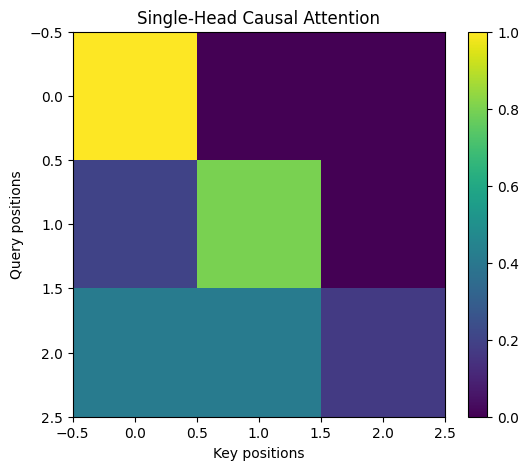

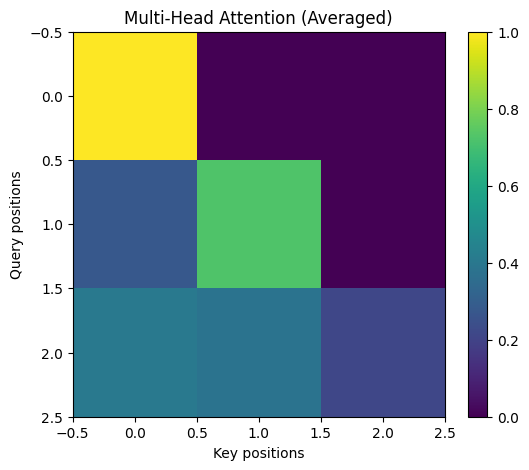

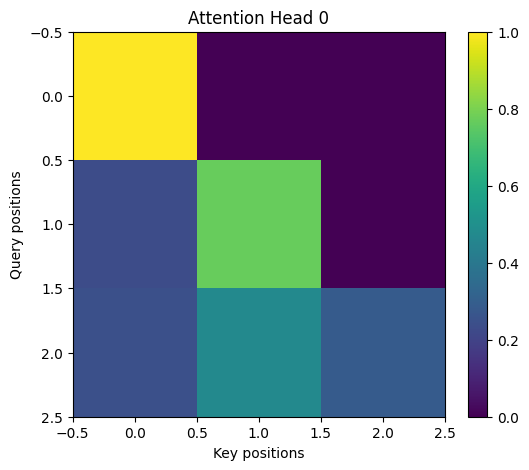

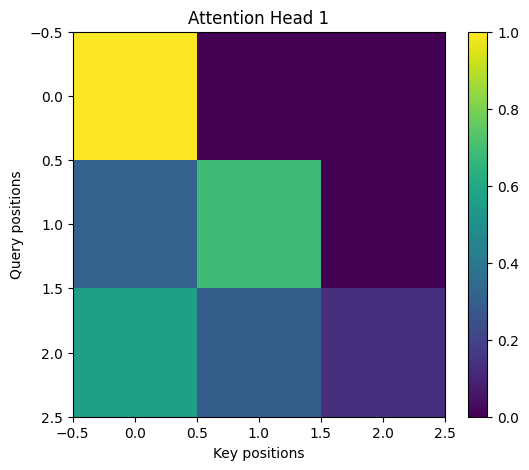


Visualization complete!


In [8]:
# Visualize Attention Patterns
print("Visualizing attention patterns")

import matplotlib.pyplot as plt


def show_attn(weights, title=""):
    """Visualize attention weights as a heatmap."""
    # Average through heads if 3D
    w = weights.mean(0) if weights.ndim == 3 else weights

    plt.figure(figsize=(6, 5))
    plt.imshow(w.detach().float().cpu().numpy(), aspect="auto", cmap="viridis")
    plt.xlabel("Key positions")
    plt.ylabel("Query positions")
    plt.title(title)
    plt.colorbar()
    plt.show()


# Visualize single-head attention
show_attn(attention_weights[0], title="Single-Head Causal Attention")

# Visualize multi-head attention (averaged)
show_attn(multi_head_weights[0], title="Multi-Head Attention (Averaged)")

# Visualize individual heads
for head_idx in range(num_heads):
    show_attn(multi_head_weights[0, head_idx], title=f"Attention Head {head_idx}")

print("\nVisualization complete!")

In [9]:
# Final Output Projection and Analysis
print("Applying final output projection and comprehensive analysis")

# Step 1: Apply output projection
final_output = o_proj(multi_head_output)
print(f"Final output shape: {final_output.shape}")
print("Final output (batch 0):")
print(final_output[0])

# Step 2: Compare single-head vs multi-head attention
print("\nSingle-head vs Multi-head Comparison:")
print(f"Single-head output norm: {attention_output.norm(dim=-1).mean().item():.4f}")
print(f"Multi-head output norm:  {final_output.norm(dim=-1).mean().item():.4f}")

# Step 3: Analyze the transformation
input_to_output_change = (final_output - hidden_states).norm(dim=-1).mean().item()
print("\nTransformation analysis:")
print(f"Average change from input to output: {input_to_output_change:.4f}")

# Step 4: Attention mechanism summary
print("\nAttention Mechanism Summary:")
print("=" * 50)

# Calculate total parameters
total_params = sum(param.numel() for proj in [q_proj, k_proj, v_proj, o_proj] for param in proj.parameters())
print(f"Total parameters: {total_params:,}")

# Computational complexity
seq_len_squared = seq_len * seq_len
print(f"Attention complexity: O(n²d) where n={seq_len}, d={hidden_dim}")
print(f"Attention operations per batch: {seq_len_squared * hidden_dim:,}")

# Memory usage
attention_memory = batch_size * num_heads * seq_len * seq_len * 4  # 4 bytes per float32
print(f"Attention weights memory: {attention_memory:,} bytes")

# Step 5: Demonstrate scalability insights
print("\nScalability Insights:")
print("- Each doubling of sequence length increases attention cost by 4x")
print("- Multi-head attention adds minimal computational overhead")
print("- Most computation is in Q,K,V projections and attention weights")
print("- GPU parallelization makes multi-head attention efficient")

# Step 6: Show attention interpretability
print("\nAttention Interpretability:")
max_attention_pos = multi_head_weights[0, 0, -1, :].argmax().item()
max_attention_val = multi_head_weights[0, 0, -1, max_attention_pos].item()
print(f"Last position (pos {seq_len - 1}) attends most to position {max_attention_pos}")
print(f"Maximum attention weight: {max_attention_val:.4f}")

print("\nAttention mechanism implementation complete!")
print("This forms the core of transformer architectures like GPT, BERT, and T5")

Applying final output projection and comprehensive analysis
Final output shape: torch.Size([2, 3, 4])
Final output (batch 0):
tensor([[-2.8048,  0.8286, -0.7160,  0.1611],
        [-1.2967, -0.0659, -1.5599,  0.2840],
        [-1.5152,  0.2548, -0.8387,  0.2782]], device='cuda:0',
       grad_fn=<SelectBackward0>)

Single-head vs Multi-head Comparison:
Single-head output norm: 2.3157
Multi-head output norm:  1.9745

Transformation analysis:
Average change from input to output: 3.3460

Attention Mechanism Summary:
Total parameters: 64
Attention complexity: O(n²d) where n=3, d=4
Attention operations per batch: 36
Attention weights memory: 144 bytes

Scalability Insights:
- Each doubling of sequence length increases attention cost by 4x
- Multi-head attention adds minimal computational overhead
- Most computation is in Q,K,V projections and attention weights
- GPU parallelization makes multi-head attention efficient

Attention Interpretability:
Last position (pos 2) attends most to positi

## Lab Summary

### Technical Concepts Learned
- **Q, K, V Projections**: Understanding Query, Key, Value transformations and their roles in computing attention
- **Scaled Dot-Product Attention**: Computing attention scores with scaling factor √d_k for numerical stability
- **Causal Masking**: Implementing autoregressive masks to prevent attending to future positions
- **Multi-Head Attention**: Splitting dimensions across parallel heads for diverse representation learning
- **Attention Complexity**: Understanding O(n²d) time and O(n²) space complexity for sequence length n

### Experiment Further
- Implement Flash Attention to reduce memory usage for long sequences
- Visualize attention patterns on real text to interpret what the model learns
- Compare single-head vs multi-head attention on a downstream task
- Implement cross-attention for encoder-decoder architectures
- Test different numbers of attention heads and analyze their learned patterns